<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(1)_DA_scVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import preprocessed Anndata object for four biological replicates, SRR26046013 (cells treated with AOA inhibitor), and SRR26046019 (untreated cells).
Following steps were performed in the preprocessing:
(1) Import matrices
(2) Compute fragment size distribution
(3) Compute TSS enrichment
(4) Filter cell counts based on TSSe
(5) Create cell by bin matrix based on 500 bp wide bins accross the whole genome
(6) Perform feature selection
(7) Perform Doublet removal
(8) Perform Dim reduction (spectral)
(9) Perform Clustering (neighborhood, UMAP, leiden)
(10) Create a cell by gene matrix
(11) Concatenate matrices using Inner join
(12) Remove batch effects

This file focuses on DA analysis using scvi package.

In [1]:
!pip install snapatac2 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scvi-tools 1.2.2.post2 requires anndata>=0.11, but you have anndata 0.10.9 which is incompatible.


In [ ]:
!pip install snapatac2 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scvi-tools 1.2.2.post2 requires anndata>=0.11, but you have anndata 0.10.9 which is incompatible.


In [2]:
!pip show snapatac2

Name: snapatac2
Version: 2.8.0
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [3]:
import snapatac2 as snap

In [4]:
!pip install umap-learn -q

In [5]:
import umap.umap_ as umap


In [6]:
from umap import UMAP

In [7]:
!pip install scanpy -q

In [8]:
import scanpy as sc

In [9]:
!pip install harmonypy -q

In [10]:
import scanpy.external as sce

In [11]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: https://scanpy.org
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [12]:
!pip install tqdm -q

In [13]:
import numpy as np

In [14]:
import anndata as ad

In [15]:
import matplotlib.pyplot as plt

In [16]:
import seaborn as sns

In [17]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [18]:
from scipy import stats

In [19]:
import pandas as pd

In [20]:
from tqdm.notebook import tqdm

# Import reads from google drive, one sample treated with energy metabolism inhibitors and one untreated

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
SRR26046013_DM_AOA_INH = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/SRR26046013_Annotated_data_matrix.h5ad')

In [23]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 13546 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [24]:
SRR26046019_DM_UT = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/SRR26046019_Annotated_data_matrix.h5ad')

In [25]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 10448 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

# Compute fragment size distributions

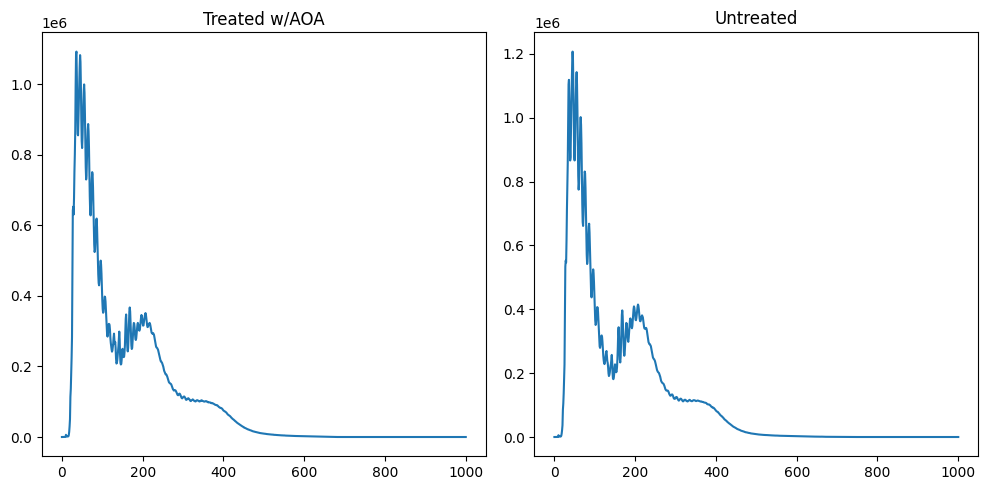

In [26]:
# Create a subplot figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot for SRR26046013_DM_AOA_INH
frag_size_distr = snap.metrics.frag_size_distr(SRR26046013_DM_AOA_INH, inplace=False)
axes[0].plot(frag_size_distr)
axes[0].set_title('Treated w/AOA')

# Plot for SRR26046019_DM_UT
frag_size_distr4 = snap.metrics.frag_size_distr(SRR26046019_DM_UT, inplace=False)
axes[1].plot(frag_size_distr4)
axes[1].set_title('Untreated')

plt.tight_layout()
plt.show()

# Compute and plot TSSe

In [27]:
# Compute TSSe metrics
# Get genome annotation
gene_anno = snap.genome.hg38

In [28]:
snap.metrics.tsse(SRR26046013_DM_AOA_INH, gene_anno)

In [29]:
snap.metrics.tsse(SRR26046019_DM_UT, gene_anno)

In [30]:
# Generate TSSE plots
TSSE1plot = snap.pl.tsse(SRR26046013_DM_AOA_INH, show = False)
TSSE2plot = snap.pl.tsse(SRR26046019_DM_UT,show = False)

# Create a subplot figure
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Treated w/AOA', 'Untreated'))

# Add the plots to the subplot figure
fig.add_trace(TSSE1plot.data[0], row=1, col=1)
fig.add_trace(TSSE2plot.data[0], row=1, col=2)

# Update layout and set X-axis to logarithmic scale
fig.update_layout(height=400, width=800, title_text="TSS enrichment")
fig.update_xaxes(type="log", row=1, col=1)
fig.update_xaxes(type="log", row=1, col=2)

fig.show()
fig.write_image("TSSE_plots.png", height=1080, width=1920)

/usr/local/lib/python3.10/dist-packages/snapatac2/plotting/__init__.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = adata.obs["n_fragment"][selected_cells]
/usr/local/lib/python3.10/dist-packages/snapatac2/plotting/__init__.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = adata.obs["tsse"][selected_cells]
/usr/local/lib/python3.10/dist-packages/snapatac2/plotting/__init__.py:97: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

In [31]:
gene_anno

fig.write_image("TSSe_plot.png",  width=1920, height=1080)

#Filter cell counts and TSSE values based on above plots

In [32]:
snap.pp.filter_cells(SRR26046013_DM_AOA_INH, min_counts=5000, min_tsse=15, max_counts=70000)

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



In [33]:
snap.pp.filter_cells(SRR26046019_DM_UT, min_counts=7000, min_tsse=13, max_counts=90000)

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



In [34]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6319 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

In [35]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 5688 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

Write to file
SRR26046013_DM_AOA_INH.write_h5ad('SRR26046013_DM_AOA_INH_filt.h5ad')
SRR26046019_DM_UT.write_h5ad('SRR26046018_DM_UT_filt.h5ad')

# Create cell by bin matrix containing insertion counts across genome-wide 500-bp bins

In [36]:
snap.pp.add_tile_matrix(SRR26046013_DM_AOA_INH)

In [37]:
snap.pp.add_tile_matrix(SRR26046019_DM_UT)

In [38]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6319 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

In [39]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 5688 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

# Add experiment info to barcodes

In [40]:
#Modify barcode names to reflect experiment number
new_barcode_names_1 = SRR26046013_DM_AOA_INH.obs_names + '_1'
new_barcode_names_1

Index(['AAACAACGAACGAGCA_1', 'AAACAACGAAGAGGCT_1', 'AAACAACGAAGTCGGA_1',
       'AAACAACGAGAAGGCT_1', 'AAACAACGAGTACGTT_1', 'AAACACGCTATCCTTT_1',
       'AAACACGCTCAGTCTA_1', 'AAACACGCTCATACTG_1', 'AAACACGCTCCAAACT_1',
       'AAACACGCTCTACTCC_1',
       ...
       'TTTGCGGCTTTCTGAG_1', 'TTTGGGAACACAGATA_1', 'TTTGGGAACAGTACGG_1',
       'TTTGGGAACCCCGCAA_1', 'TTTGGGAACTAACGGG_1', 'TTTGGGAACTGGTCCG_1',
       'TTTGGGATGCCTGCGA_1', 'TTTGGGATGGCGGTTC_1', 'TTTGGGATGTTAGCTG_1',
       'TTTGGGATGTTGCGTA_1'],
      dtype='object', name='index', length=6319)

In [41]:
#Update barcode names
SRR26046013_DM_AOA_INH.obs_names = new_barcode_names_1

In [42]:
SRR26046013_DM_AOA_INH.obs_names

Index(['AAACAACGAACGAGCA_1', 'AAACAACGAAGAGGCT_1', 'AAACAACGAAGTCGGA_1',
       'AAACAACGAGAAGGCT_1', 'AAACAACGAGTACGTT_1', 'AAACACGCTATCCTTT_1',
       'AAACACGCTCAGTCTA_1', 'AAACACGCTCATACTG_1', 'AAACACGCTCCAAACT_1',
       'AAACACGCTCTACTCC_1',
       ...
       'TTTGCGGCTTTCTGAG_1', 'TTTGGGAACACAGATA_1', 'TTTGGGAACAGTACGG_1',
       'TTTGGGAACCCCGCAA_1', 'TTTGGGAACTAACGGG_1', 'TTTGGGAACTGGTCCG_1',
       'TTTGGGATGCCTGCGA_1', 'TTTGGGATGGCGGTTC_1', 'TTTGGGATGTTAGCTG_1',
       'TTTGGGATGTTGCGTA_1'],
      dtype='object', name='index', length=6319)

In [43]:
#Modify barcode names to reflect experiment number
new_barcode_names_2 = SRR26046019_DM_UT.obs_names + '_2'
new_barcode_names_2

Index(['AAACAACGATAAGTAG_2', 'AAACAACGATAGGTTC_2', 'AAACAACGATCTATCT_2',
       'AAACAACGATGCGTGC_2', 'AAACAACGATTGCGCG_2', 'AAACACGCTCGCAACC_2',
       'AAACACGCTCGGAATG_2', 'AAACACGCTGCGCTGT_2', 'AAACACGCTTGCCACG_2',
       'AAACACGCTTGGGCAA_2',
       ...
       'TTTGGGAACCGACATT_2', 'TTTGGGAACCGAGTGA_2', 'TTTGGGAACGAAGTTA_2',
       'TTTGGGAACTGACCTA_2', 'TTTGGGATGAACGCAG_2', 'TTTGGGATGAACGTAA_2',
       'TTTGGGATGAAGTCTC_2', 'TTTGGGATGATGTGGG_2', 'TTTGGGATGCTCACGG_2',
       'TTTGGGATGCTCTGGG_2'],
      dtype='object', name='index', length=5688)

In [44]:
#Update barcode names
SRR26046019_DM_UT.obs_names = new_barcode_names_2

In [45]:
SRR26046019_DM_UT.obs_names

Index(['AAACAACGATAAGTAG_2', 'AAACAACGATAGGTTC_2', 'AAACAACGATCTATCT_2',
       'AAACAACGATGCGTGC_2', 'AAACAACGATTGCGCG_2', 'AAACACGCTCGCAACC_2',
       'AAACACGCTCGGAATG_2', 'AAACACGCTGCGCTGT_2', 'AAACACGCTTGCCACG_2',
       'AAACACGCTTGGGCAA_2',
       ...
       'TTTGGGAACCGACATT_2', 'TTTGGGAACCGAGTGA_2', 'TTTGGGAACGAAGTTA_2',
       'TTTGGGAACTGACCTA_2', 'TTTGGGATGAACGCAG_2', 'TTTGGGATGAACGTAA_2',
       'TTTGGGATGAAGTCTC_2', 'TTTGGGATGATGTGGG_2', 'TTTGGGATGCTCACGG_2',
       'TTTGGGATGCTCTGGG_2'],
      dtype='object', name='index', length=5688)

# Join the matrices

In [46]:
adata_combined = ad.concat([SRR26046013_DM_AOA_INH, SRR26046019_DM_UT], merge='same', label='Treatment', keys=['Treated w/AOA', 'Untreated'], join='inner')

# Identify highly variable genes for each AnnData object
sc.pp.highly_variable_genes(SRR26046013_DM_AOA_INH, flavor='seurat', n_top_genes=1000)
sc.pp.highly_variable_genes(SRR26046019_DM_UT, flavor='seurat', n_top_genes=1000)

# Subset to the top 1000 highly variable features
SRR26046013_DM_AOA_INH = SRR26046013_DM_AOA_INH[:, SRR26046013_DM_AOA_INH.var['highly_variable']].copy()
SRR26046019_DM_UT = SRR26046019_DM_UT[:, SRR26046019_DM_UT.var['highly_variable']].copy()

SRR26046013_DM_AOA_INH

SRR26046019_DM_UT

print(SRR26046013_DM_AOA_INH.X.format)


print(SRR26046019_DM_UT.X.format)

!pip install memory_profiler -q

In [47]:
adata_combined

AnnData object with n_obs × n_vars = 12007 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'Treatment'
    obsm: 'fragment_paired'

# scvi analysis

In [48]:
!pip install scvi-tools -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
snapatac2 2.8.0 requires anndata<0.11.0,>=0.8.0, but you have anndata 0.11.3 which is incompatible.


In [ ]:
!pip install scvi-tools -q

In [ ]:
import scvi



In [ ]:
scvi.data.setup_anndata(adata_combined, layer="counts", matrix_type="atac")